In [1]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO

import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show 
import matplotlib.patches as patches    
from matplotlib import colors


import glob

import subprocess
from subprocess import call

import re

import pickle

from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

from scipy import stats


from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

import joypy

/home/alla/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# open metadata with scores and metrics
meta = pd.read_csv('tmp_res/METADATA_CURRENT.txt', sep='\t')

# gencode 25
metadata_pc_g25 = pd.read_csv('tmp_res/metadata_pc_g25.txt', sep='\t')


P_Set = pd.read_csv('tmp_res/SET1.txt', sep='\t')

R_Set = pd.read_csv('tmp_res/SET2.txt', sep='\t')

R_Set['pos_of_codon'] = [int(x.split('; ')[1].split('-')[0])-1 for x in R_Set.Riboseq_Summary.tolist()]

R_Set['codon'] = [x.split('; ')[0] for x in R_Set.Riboseq_Summary.tolist()]

R_Set[0:2]

,tr_id,gene,N_term_start1,N_term_end1,len_codons,global_coo_50_and_less,strand,global_coo_primary,PhyloCSF120score,number_of_records,ovlp,Riboseq_Summary,Coverage_value_ext,Proteomics_count_ext,tag,transcript_type,CDS_ratio,pos_of_codon,codon
0,ENST00000379389.4,ISG15,1,151,50.0,chr1:1013424-1013573,+,chr1:1013424-1013573,-2443.9971,111,0;0;0,ATC; 98-152; Rank: 288; cov: 53.85,53.846154,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.327240,97,ATC
1,ENST00000349431.10,UBE2J2,28,220,64.0,chr1:1273666-1273815,-,chr1:1273666-1273857,-1285.8186,78,0;0;0,ACG; 173-221; Rank: 328; cov: 90.91,90.909091,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.762814,172,ACG


## Read alignments -> make dicts like ({specie1: CTG, specie2: CTT, specie3: CTA}) -> list of species with the same nonAUG codon as human ref

In [3]:
def get_aln(fasta_input):
    aln_col = []
    ids_li = []
    
    with open(fasta_input, 'r') as input_handle:
        for record in SeqIO.parse(input_handle, "fasta"):
            seq = str(record.seq)
            ids = str(record.id)
            aln_col.append([seq[i:i+1] for i in range(0, len(seq), 1)])
            ids_li.append(ids)
    return aln_col, ids_li

def re_index_with_gaps(aln_col):
    new_col_ind = []

    # take ref seq
    counter_pos = 0 # to exclude '-'

    for col in pd.DataFrame(aln_col).to_numpy()[0]:
        if (col == '-') | (col == '.'): # UCC UGA C = TCC TGA C
            new_col_ind.append(counter_pos)
        else: 
            counter_pos += 1
            new_col_ind.append(counter_pos)
    
    return new_col_ind


def slice_aln(aln_col, new_col_ind, a, b):
    fr_stop_motif_array = []
    for row in pd.DataFrame(aln_col).to_numpy():
        tmp = []
        for ind, col in zip(new_col_ind, row):
            if (ind >= a) & (ind <= b):
                tmp.append(col)
            
        fr_stop_motif_array.append(tmp)
    
    return fr_stop_motif_array


In [4]:
li = []

kek = {}

for i, el in enumerate(R_Set[['tr_id', 'gene', 'pos_of_codon']].merge(meta[['tr_id', 'N_term_start1', 'global_coo_primary']], on='tr_id', how='inner').to_numpy()):
    tr_id = el[0]
    
    #print (tr_id)
    chrom = el[-1].split(':')[0]
    nte_start = el[-2]
    pos_of_codon = el[2]
    
    a = pos_of_codon - nte_start + 1
    
    b = a + 2
    
    fasta_input = 'data/nte_full_aln/out/%s/fasta3/%s.fasta' % (chrom, tr_id)

    aln_col, ids_li = get_aln(fasta_input)
    new_col_ind = re_index_with_gaps(aln_col)
    sliced_array = slice_aln(aln_col, new_col_ind, a, b)
    
    a1 = pos_of_codon - nte_start + 1 - 4
    b1 = pos_of_codon - nte_start + 1 + 4
    sliced_array_TIS = slice_aln(aln_col, new_col_ind, a1, b1)
    sliced_array_TIS_and_surroundings = slice_aln(aln_col, new_col_ind, a1-15, b1+15)
    
    # check conservation
    # fraction of the exact reference codon 
    # Counter of near-cognate codons 
    ref_codon = ''.join(pd.DataFrame(sliced_array).to_numpy()[0]).replace('-', '')
    
    #if tr_id == 'ENST00000341772.4':
        #print (pd.DataFrame(sliced_array))
    
    number_of_species  = len(aln_col)
    
    codons = [''.join(list(x)).replace('-', '') for x in pd.DataFrame(sliced_array).to_numpy()[0:]]
    
    ref_codon_count = codons.count(ref_codon)
    
    # count of all non-cognate + AUG
    non_cognates = ['ATG', 'CTG', 'TTG', 'GTG', 'ATC', 'ATT', 'ATA', 'AGG', 'AAG', 'ACG']
    
    non_cognates_codon_count = 0
    for codon in non_cognates:
        non_cognates_codon_count += codons.count(codon)
    
    ref_codon_fraction = ref_codon_count / number_of_species
    near_cognate_codong_fraction = non_cognates_codon_count / number_of_species
    
    counter_codon = Counter(codons)
    
    if i % 10 == 0:
        print (i)
        
    kek[tr_id] = [sliced_array, aln_col,sliced_array_TIS,sliced_array_TIS_and_surroundings,ids_li]
    
    dict_animals = dict(zip(ids_li[1:], codons))
    
    li.append([tr_id, el[2], nte_start, ref_codon, number_of_species, ref_codon_count, ref_codon_fraction, counter_codon,
              non_cognates_codon_count, near_cognate_codong_fraction, dict_animals, ids_li])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390


In [5]:
conservation_df = pd.DataFrame(li, columns = ['tr_id', 'codon_start', 'nte_start', 'ref_codon', 
                                  'number_of_species', 'ref_codon_count', 
                                  'ref_codon_fraction', 'counter_codon', 
                                 'near_cognate_codon_count', 'near_cognate_codon_fraction',
                                             'specie_codon_dict', 'animals_li'])

conservation_df = conservation_df.merge(metadata_pc_g25[['tr_id', 'gene']], on='tr_id', how='inner')

# exclude ATG extensions
conservation_df = conservation_df[conservation_df['codon_start'] != 'ATG']

print (conservation_df.shape)
conservation_df[0:2]

(395, 13)


,tr_id,codon_start,nte_start,ref_codon,number_of_species,ref_codon_count,ref_codon_fraction,counter_codon,near_cognate_codon_count,near_cognate_codon_fraction,specie_codon_dict,animals_li,gene
0,ENST00000379389.4,97,1,ATC,111,33,0.297297,"{'ATC': 33, 'TTC': 2, '': 7, 'GTCTTCGCCCGACCGG...",36,0.324324,"{'Chimp': 'ATC', 'Bonobo': 'ATC', 'Gorilla': '...","[Human, Chimp, Bonobo, Gorilla, Orangutan, Gib...",ISG15
1,ENST00000349431.10,172,28,ACG,82,58,0.707317,"{'ACG': 58, 'ACA': 1, 'AGG': 2, 'GCA': 1, 'GCG...",60,0.731707,"{'Chimp': 'ACG', 'Bonobo': 'ACG', 'Gorilla': '...","[Human, Chimp, Bonobo, Gorilla, Orangutan, Gib...",UBE2J2


In [6]:
conservation_df[['tr_id', 'ref_codon', 'specie_codon_dict', 'gene']][0:5]

,tr_id,ref_codon,specie_codon_dict,gene
0,ENST00000379389.4,ATC,"{'Chimp': 'ATC', 'Bonobo': 'ATC', 'Gorilla': '...",ISG15
1,ENST00000349431.10,ACG,"{'Chimp': 'ACG', 'Bonobo': 'ACG', 'Gorilla': '...",UBE2J2
2,ENST00000338370.7,ATT,"{'Chimp': 'ATT', 'Bonobo': 'ATT', 'Gorilla': '...",AURKAIP1
3,ENST00000235310.7,GTG,"{'Chimp': 'GTG', 'Bonobo': 'GTG', 'Gorilla': '...",MAD2L2
4,ENST00000356634.7,GTG,"{'Chimp': 'GTG', 'Bonobo': 'GTG', 'Gorilla': '...",KDM1A


## Add phylogenetic tree -> order species (or taxonomic group) by evolutionary distance 

In [7]:
from Bio import Phylo

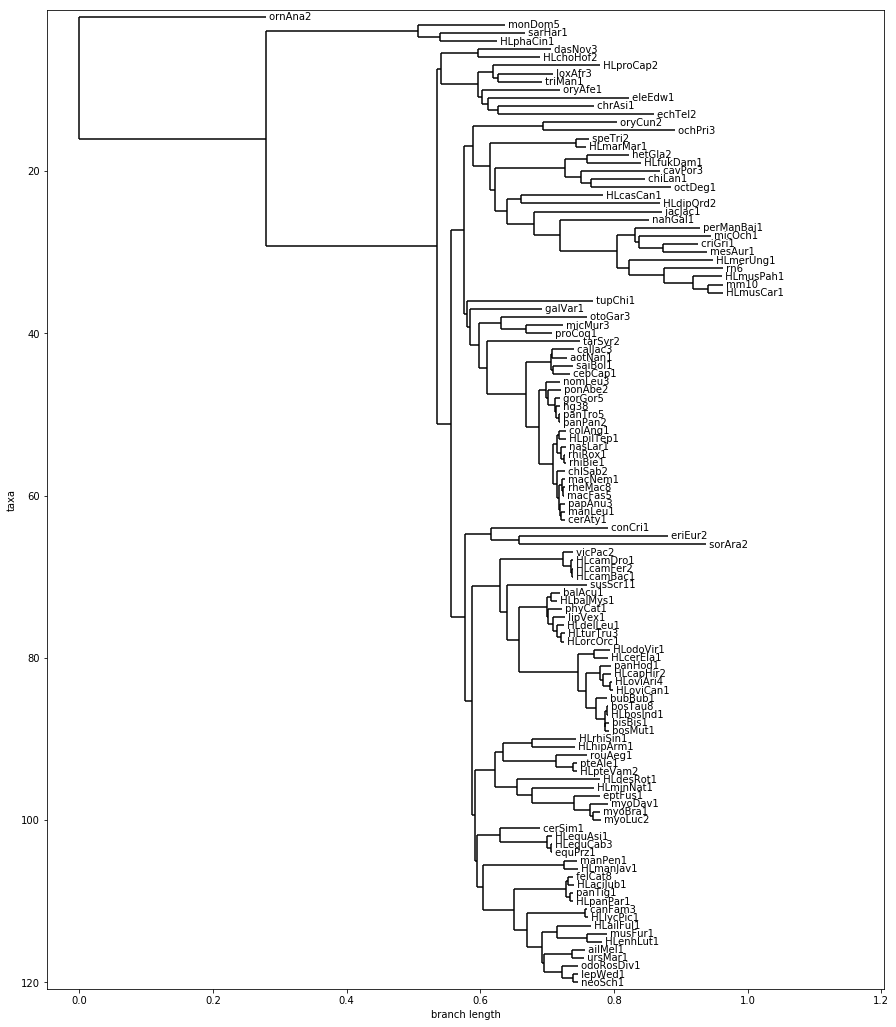

In [8]:
tree = Phylo.read("data/tree_hg38_assembly_120mammal.nh", "newick")
#print(tree)

fig, ax = plt.subplots(figsize=(15,18))

tree.ladderize()  # Flip branches so deeper clades are displayed at top
Phylo.draw(tree, axes=ax)

In [9]:
Phylo.draw_ascii(tree)

  ________________ ornAna2
 |
 |                                _______ monDom5
 |                 ______________|
 |                |              |  _______ sarHar1
 |                |              |_|
 |                |                |_____ HLphaCin1
 |                |
 |                |                     ______ dasNov3
 |                |                 ___|
 |                |                |   |_____ HLchoHof2
 |                |                |
 |                |                |     __________ HLproCap2
 |                |                |   ,|
_|                |                |   || ____ loxAfr3
 |                |                |   |||
 |                |                |___| |___ triMan1
 |                |                |   |
 |                |                |   |_______ oryAfe1
 |                |                |   |
 |                |                |   | ____________ eleEdw1
 |                |                |   ||
 |                |                | 

In [10]:
loop_over_tree_li = []

for terminal in tree.get_terminals():
    loop_over_tree_li.append(terminal.name)

In [11]:
loop_over_tree_li

['ornAna2',
 'monDom5',
 'sarHar1',
 'HLphaCin1',
 'dasNov3',
 'HLchoHof2',
 'HLproCap2',
 'loxAfr3',
 'triMan1',
 'oryAfe1',
 'eleEdw1',
 'chrAsi1',
 'echTel2',
 'oryCun2',
 'ochPri3',
 'speTri2',
 'HLmarMar1',
 'hetGla2',
 'HLfukDam1',
 'cavPor3',
 'chiLan1',
 'octDeg1',
 'HLcasCan1',
 'HLdipOrd2',
 'jacJac1',
 'nanGal1',
 'perManBai1',
 'micOch1',
 'criGri1',
 'mesAur1',
 'HLmerUng1',
 'rn6',
 'HLmusPah1',
 'mm10',
 'HLmusCar1',
 'tupChi1',
 'galVar1',
 'otoGar3',
 'micMur3',
 'proCoq1',
 'tarSyr2',
 'calJac3',
 'aotNan1',
 'saiBol1',
 'cebCap1',
 'nomLeu3',
 'ponAbe2',
 'gorGor5',
 'hg38',
 'panTro5',
 'panPan2',
 'colAng1',
 'HLpilTep1',
 'nasLar1',
 'rhiRox1',
 'rhiBie1',
 'chlSab2',
 'macNem1',
 'rheMac8',
 'macFas5',
 'papAnu3',
 'manLeu1',
 'cerAty1',
 'conCri1',
 'eriEur2',
 'sorAra2',
 'vicPac2',
 'HLcamDro1',
 'HLcamFer2',
 'HLcamBac1',
 'susScr11',
 'balAcu1',
 'HLbalMys1',
 'phyCat1',
 'lipVex1',
 'HLdelLeu1',
 'HLturTru3',
 'HLorcOrc1',
 'HLodoVir1',
 'HLcerEla1',
 'panH

# get distance between hg39 and other species in a tree

In [12]:
meta_animals = pd.read_csv('data/120way_animals.txt', sep='\t', header=None)


In [13]:
#! /usr/bin/env python

import dendropy
from dendropy import treecalc

tree = dendropy.Tree.get_from_path("data/tree_hg38_assembly_120mammal.nh", "newick")
pdm = tree.phylogenetic_distance_matrix() # patristic distances on the tree

In [14]:
distance_d = {}

for i, t1 in enumerate(tree.taxon_set):
    for t2 in tree.taxon_set[i+1:]:
        if t1.label == 'hg38':
            #print("Distance between '%s' and '%s': %s" % (t1.label, t2.label, pdm(t1, t2)))
            label = re.sub(r'\d+', '', t2.label)
            specie = meta_animals[meta_animals[0].str.contains(label)].iloc[0][1]
            distance_d[specie] = pdm(t1, t2)

/home/alla/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3242: CriticalDeprecationWarning: Deprecated since DendroPy 4: 'taxon_set' will no longer be supported in future releases; use 'taxon_namespace' instead
  if (await self.run_code(code, result,  async_=asy)):


In [15]:
taxonomy = pd.read_csv('data/taxonomy.txt', sep='\t', header=None)
taxonomy['label'] = [x.split(': ')[1] for x in taxonomy[1].tolist()]
taxonomy['species'] = [x.split(' (')[0].replace(' ', '_').replace('-', '_') for x in taxonomy[1].tolist()]

In [16]:
len(list(distance_d.keys()))

119

In [17]:
pd.DataFrame({'species': list(distance_d.keys()), 'distance': list(distance_d.values())}).sort_values(by='distance')[-10:]

,species,distance
36,Mongolian_gerbil,0.515023
34,Shrew_mouse,0.528646
35,Rat,0.530502
33,Ryukyu_mouse,0.530756
32,Mouse,0.530890
104,Shrew,0.545244
117,Koala,0.787685
115,Opossum,0.798597
116,Tasmanian_devil,0.828433
118,Platypus,0.998144


In [18]:
taxonomy = taxonomy.replace({'David_s_myotis':'Davids_myotis'})
taxonomy = taxonomy.replace({'Brandt_s_myotis':'Brandts_myotis'})

In [19]:
taxonomy[taxonomy['species'].str.contains('myotis')]

,0,1,label,species
98,Chiroptera,David s myotis (bat) (Myotis davidii): myoDav1,myoDav1,Davids_myotis
99,Chiroptera,Brandt s myotis (bat) (Myotis brandtii): myoBra1,myoBra1,Brandts_myotis


# Get the furthest specie with the same codon as ref 

In [20]:
conservation_df[['tr_id', 'ref_codon', 'specie_codon_dict', 'gene']][0:5]

,tr_id,ref_codon,specie_codon_dict,gene
0,ENST00000379389.4,ATC,"{'Chimp': 'ATC', 'Bonobo': 'ATC', 'Gorilla': '...",ISG15
1,ENST00000349431.10,ACG,"{'Chimp': 'ACG', 'Bonobo': 'ACG', 'Gorilla': '...",UBE2J2
2,ENST00000338370.7,ATT,"{'Chimp': 'ATT', 'Bonobo': 'ATT', 'Gorilla': '...",AURKAIP1
3,ENST00000235310.7,GTG,"{'Chimp': 'GTG', 'Bonobo': 'GTG', 'Gorilla': '...",MAD2L2
4,ENST00000356634.7,GTG,"{'Chimp': 'GTG', 'Bonobo': 'GTG', 'Gorilla': '...",KDM1A


In [21]:
conservation_df.shape[0]

395

In [22]:
li = []

gene_count = {}

for el in conservation_df[['tr_id', 'ref_codon', 'specie_codon_dict', 'gene']].to_numpy():
    tr_id = el[0]
    ref_codon = el[1]
    specie_codon_dict = el[2]
    gene = el[3]
    
    gene_count[tr_id] = 0
    
    for specie, codon in specie_codon_dict.items():
        if ref_codon != 'ATG':
            if codon == 'ATG':
                #print (tr_id, ref_codon, codon, gene, specie)
                gene_count[tr_id] += 1
            

In [23]:
gene_count

{'ENST00000379389.4': 0,
 'ENST00000349431.10': 0,
 'ENST00000338370.7': 0,
 'ENST00000235310.7': 0,
 'ENST00000356634.7': 0,
 'ENST00000374612.5': 0,
 'ENST00000617979.4': 0,
 'ENST00000399728.5': 0,
 'ENST00000321265.9': 0,
 'ENST00000327300.11': 0,
 'ENST00000373493.9': 0,
 'ENST00000373477.8': 0,
 'ENST00000521580.2': 0,
 'ENST00000611874.4': 0,
 'ENST00000357214.5': 0,
 'ENST00000321358.11': 0,
 'ENST00000371655.3': 0,
 'ENST00000313334.12': 0,
 'ENST00000302118.5': 0,
 'ENST00000371222.3': 0,
 'ENST00000370986.8': 0,
 'ENST00000370938.7': 0,
 'ENST00000370544.9': 0,
 'ENST00000370238.7': 0,
 'ENST00000334047.11': 0,
 'ENST00000370109.7': 0,
 'ENST00000370035.7': 0,
 'ENST00000369799.9': 0,
 'ENST00000413052.6': 0,
 'ENST00000271715.6': 1,
 'ENST00000368811.7': 0,
 'ENST00000368694.7': 0,
 'ENST00000356955.6': 0,
 'ENST00000361168.9': 0,
 'ENST00000368216.8': 0,
 'ENST00000357325.9': 0,
 'ENST00000367879.8': 0,
 'ENST00000236137.9': 0,
 'ENST00000340385.5': 0,
 'ENST00000258341.4'

In [24]:
li = []

for el in conservation_df[['tr_id', 'ref_codon', 'specie_codon_dict', 'gene']].to_numpy():
    tr_id = el[0]
    ref_codon = el[1]
    specie_codon_dict = el[2]
    gene = el[3]
    
    the_furthest_animal_d = {}
    
    orders = []
    
    for specie, codon in specie_codon_dict.items():
        if codon == ref_codon:
            dist = distance_d[specie]
            the_furthest_animal_d[specie] = dist
            
            print (specie)
            order = taxonomy[taxonomy['species'] == specie].iloc[0][0]
            print (order)
            orders.append(order)
            
    the_furthest_animal = max(the_furthest_animal_d, key=the_furthest_animal_d.get)
    the_furthest_animal_dist = the_furthest_animal_d[the_furthest_animal]
    
    li.append([tr_id, gene, ref_codon, the_furthest_animal, the_furthest_animal_dist, 
              the_furthest_animal_d, specie_codon_dict, Counter(orders)])

Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Green_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
Squirrel_monkey
Primatomorpha
Chinese_tree_shrew
Primatomorpha
Chinese_hamster
Glires
Bactrian_camel
Cetartiodactyla
Arabian_camel
Cetartiodactyla
Killer_whale
Cetartiodactyla
African_hunting_dog
Ferae
Ferret
Ferae
Pacific_walrus
Ferae
Malayan_pangolin
Ferae
Black_flying_fox
Chiroptera
Great_roundleaf_bat
Chiroptera
Big_brown_bat
Chiroptera
Natal_long_fingered_bat
Chiroptera
Common_vampire_bat
Chiroptera
Hedgehog
Eulipotyphla
Cape_elephant_shrew
Atlantogenata
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Prim

Perissodactyla
Ass
Perissodactyla
White_rhinoceros
Perissodactyla
Cat
Ferae
Cheetah
Ferae
Amur_tiger
Ferae
Leopard
Ferae
Dog
Ferae
Sea_otter
Ferae
Lesser_panda
Ferae
Panda
Ferae
Polar_bear
Ferae
Pacific_walrus
Ferae
Weddell_seal
Ferae
Hawaiian_monk_seal
Ferae
Chinese_pangolin
Ferae
Malayan_pangolin
Ferae
Black_flying_fox
Chiroptera
Davids_myotis
Chiroptera
Brandts_myotis
Chiroptera
Microbat
Chiroptera
Natal_long_fingered_bat
Chiroptera
Common_vampire_bat
Chiroptera
Hedgehog
Eulipotyphla
Shrew
Eulipotyphla
Star_nosed_mole
Eulipotyphla
Elephant
Atlantogenata
Manatee
Atlantogenata
Cape_rock_hyrax
Atlantogenata
Cape_golden_mole
Atlantogenata
Tenrec
Atlantogenata
Cape_elephant_shrew
Atlantogenata
Aardvark
Atlantogenata
Hoffmanns_two_fingered_sloth
Atlantogenata
Opossum
NonPlacental
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Alpaca
Cetartiodactyla
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorp

Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Bushbaby
Primatomorpha
Mouse_lemur
Primatomorpha
Sifaka
Primatomorpha
Malayan_flying_lemur
Primatomorpha
Lesser_Egyptian_jerboa
Glires
Prairie_vole
Glires
Golden_hamster
Glires
Prairie_deer_mouse
Glires
Mouse
Glires
Ryukyu_mouse
Glires
Shrew_mouse
Glires
Rat
Glires
Mongolian_gerbil
Glires
Upper_Galilee_mountains_blind_mole_rat
Glires
American_beaver
Glires
Ords_kangaroo_rat
Glires
Naked_mole_rat
Glires
Damara_mole_rat
Glires
Guinea_pig
Glires
Brush_tailed_rat
Glires
Squirrel
Glires
Alpine_marmot
Glires
Rabbit
Glires
Pika
Glires
Alpaca
Cetartiodactyla
Arabian_camel
Cetartiodactyla
Killer_whale
Cetartiodactyla
Beluga_whale
Cetartiodactyla
Yangtze_river_dolphin
Cetartiodactyla
Sperm_whale
Cetartiodactyla
Minke_whale
Cetartiodactyla
Bowhead_whale
Cetartiodactyla
Cow
Cetartiodactyla

Ferae
Malayan_pangolin
Ferae
Black_flying_fox
Chiroptera
Common_vampire_bat
Chiroptera
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
Squirrel_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Mouse_lemur
Primatomorpha
Sifaka
Primatomorpha
Malayan_flying_lemur
Primatomorpha
Chinese_tree_shrew
Primatomorpha
Lesser_Egyptian_jerboa
Glires
Chinese_hamster
Glires
Mouse
Glires
Ryukyu_mouse
Glires
Shrew_mouse
Glires
Rat
Glires
Mongolian_gerbil
Glires
Upper_Galilee_mountains_blind_mole_rat
Glires
American_beaver
Glires
Ords_kangaroo_r

Eulipotyphla
Star_nosed_mole
Eulipotyphla
Elephant
Atlantogenata
Manatee
Atlantogenata
Cape_rock_hyrax
Atlantogenata
Cape_golden_mole
Atlantogenata
Tenrec
Atlantogenata
Cape_elephant_shrew
Atlantogenata
Aardvark
Atlantogenata
Armadillo
Atlantogenata
Hoffmanns_two_fingered_sloth
Atlantogenata
Opossum
NonPlacental
Koala
NonPlacental
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Crab_eating_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Green_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Marmoset
Primatomorpha
Squirrel_monkey
Primatomorpha
Tarsier
Primatomorpha
Mouse_lemur
Primatomorpha
Sifaka
Primatomorpha
Chinese_hamster
Glires
Prairie_deer_mouse
Glires
Mouse
Glires
Ryukyu_mouse
Glires
Shrew_mouse
Glires
Rat
Glires
Mongolian_gerbil
Glires
Upper_Galilee_mountains_blind_mole_rat
Glires
American_beaver
Glires
Ords_kangaroo_rat
Glires
Naked_mole_rat
Glires
Damara_mole_rat
Glires
Brush_tailed_rat
Glires
Squirrel
Glires
Wi

Cetartiodactyla
Bison
Cetartiodactyla
Wild_yak
Cetartiodactyla
Water_buffalo
Cetartiodactyla
Sheep
Cetartiodactyla
Horse
Perissodactyla
Przewalski_horse
Perissodactyla
Ass
Perissodactyla
White_rhinoceros
Perissodactyla
Cat
Ferae
Cheetah
Ferae
Leopard
Ferae
Dog
Ferae
Malayan_pangolin
Ferae
Black_flying_fox
Chiroptera
Davids_myotis
Chiroptera
Brandts_myotis
Chiroptera
Common_vampire_bat
Chiroptera
Shrew
Eulipotyphla
Star_nosed_mole
Eulipotyphla
Elephant
Atlantogenata
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
Tarsier
Primatomorpha
Mouse_lemur
Primatomorpha
Sifaka
Primatomorpha
Malayan_flying_lemur
Primatomorpha
Chinese_tree_shrew
Pri

Perissodactyla
White_rhinoceros
Perissodactyla
Cat
Ferae
Amur_tiger
Ferae
Leopard
Ferae
Dog
Ferae
African_hunting_dog
Ferae
Ferret
Ferae
Sea_otter
Ferae
Lesser_panda
Ferae
Panda
Ferae
Polar_bear
Ferae
Pacific_walrus
Ferae
Weddell_seal
Ferae
Hawaiian_monk_seal
Ferae
Chinese_pangolin
Ferae
Malayan_pangolin
Ferae
Black_flying_fox
Chiroptera
Large_flying_fox
Chiroptera
Egyptian_rousette
Chiroptera
Great_roundleaf_bat
Chiroptera
Big_brown_bat
Chiroptera
Star_nosed_mole
Eulipotyphla
Elephant
Atlantogenata
Cape_rock_hyrax
Atlantogenata
Cape_golden_mole
Atlantogenata
Tenrec
Atlantogenata
Cape_elephant_shrew
Atlantogenata
Aardvark
Atlantogenata
Armadillo
Atlantogenata
Hoffmanns_two_fingered_sloth
Atlantogenata
Chimp
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Mas_night_monkey
Primatomorpha
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomor

Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Chinchilla
Glires
Aardvark
Atlantogenata
Chimp
Primatomorpha
Bonobo
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Green_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
Squirrel_monkey
Primatomorpha
Tarsier
Primatomorpha
Mouse_lemur
Primatomorpha
Malayan_flying_lemur
Primatomorpha
Ords_kangaroo_rat
Glires
Brush_tailed_rat
Glires
Alpine_marmot
Glires
Rabbit
Glires
Wild_bactrian_camel
Cetartiodactyla
Killer_whale
Cetartiodactyla
Beluga_whale
Cetartiodactyla
Yangtze_river_dolphin
Cetartiodactyla
Zebu_cattle
Cetartiodactyla
Bison
Cetartiodactyla
Wild_yak
Cetartiodactyla
Water_buffalo
Cetartiodactyla
Bighorn_sheep
Cetartiodactyla
Tibetan_antelope
Cetartiodactyla
Red_deer
Cetartiodactyla
Pig
Cetartiodactyla
Horse

Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Proboscis_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
Squirrel_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Bushbaby
Primatomorpha
Mouse_lemur
Primatomorpha
Sifaka
Primatomorpha
Malayan_flying_lemur
Primatomorpha
Chinese_tree_shrew
Primatomorpha
Lesser_Egyptian_jerboa
Glires
Prairie_vole
Glires
Chinese_hamster
Glires
Prairie_deer_mouse
Glires
Mouse
Glires
Ryukyu_mouse
Glires
Shrew_mouse
Glires
Rat
Glires
Mongolian_gerbil
Glires
Upper_Galilee_mountains_blind_mole_rat
Glires
American_beaver
Glires
Ords_kangaroo_rat
Glires
Naked_mole_rat
Glires
Damara_mole_rat
Glires
Guinea_pig
Glires
Alpine_m

Ferae
Ferret
Ferae
Sea_otter
Ferae
Lesser_panda
Ferae
Pacific_walrus
Ferae
Weddell_seal
Ferae
Hawaiian_monk_seal
Ferae
Black_flying_fox
Chiroptera
Large_flying_fox
Chiroptera
Egyptian_rousette
Chiroptera
Chinese_rufous_horseshoe_bat
Chiroptera
Big_brown_bat
Chiroptera
Davids_myotis
Chiroptera
Brandts_myotis
Chiroptera
Microbat
Chiroptera
Common_vampire_bat
Chiroptera
Hedgehog
Eulipotyphla
Star_nosed_mole
Eulipotyphla
Elephant
Atlantogenata
Manatee
Atlantogenata
Cape_rock_hyrax
Atlantogenata
Cape_golden_mole
Atlantogenata
Tenrec
Atlantogenata
Cape_elephant_shrew
Atlantogenata
Aardvark
Atlantogenata
Armadillo
Atlantogenata
Hoffmanns_two_fingered_sloth
Atlantogenata
Koala
NonPlacental
Platypus
NonPlacental
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatom

Primatomorpha
Squirrel_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Prairie_vole
Glires
Chinese_hamster
Glires
Golden_hamster
Glires
Prairie_deer_mouse
Glires
Mouse
Glires
Ryukyu_mouse
Glires
Shrew_mouse
Glires
Rat
Glires
Mongolian_gerbil
Glires
American_beaver
Glires
Damara_mole_rat
Glires
Guinea_pig
Glires
Chinchilla
Glires
Brush_tailed_rat
Glires
Squirrel
Glires
Pika
Glires
Alpaca
Cetartiodactyla
Przewalski_horse
Perissodactyla
Ass
Perissodactyla
White_rhinoceros
Perissodactyla
Cat
Ferae
Cheetah
Ferae
Amur_tiger
Ferae
Leopard
Ferae
Dog
Ferae
Sea_otter
Ferae
Lesser_panda
Ferae
Panda
Ferae
Polar_bear
Ferae
Pacific_walrus
Ferae
Weddell_seal
Ferae
Hawaiian_monk_seal
Ferae
Malayan_pangolin
Ferae
Black_flying_fox
Chiroptera
Large_flying_fox
Chiroptera
Egyptian_rousette
Chiroptera
Chinese_rufous_horseshoe_bat
Chiroptera
Davids_myotis
Chiroptera
Brandts_myotis
Chiroptera
Microbat
Chiroptera
Natal_long_fingered_bat
Chiroptera
Common_vampire_bat
Chiroptera
Elep

Prairie_vole
Glires
Chinese_hamster
Glires
Prairie_deer_mouse
Glires
Mouse
Glires
Ryukyu_mouse
Glires
Shrew_mouse
Glires
Rat
Glires
Mongolian_gerbil
Glires
Upper_Galilee_mountains_blind_mole_rat
Glires
Ords_kangaroo_rat
Glires
Naked_mole_rat
Glires
Damara_mole_rat
Glires
Guinea_pig
Glires
Chinchilla
Glires
Brush_tailed_rat
Glires
Squirrel
Glires
Alpine_marmot
Glires
Pika
Glires
Microbat
Chiroptera
Natal_long_fingered_bat
Chiroptera
Manatee
Atlantogenata
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mouse_lemur
Primatomorpha
Sifaka
Primatomorpha
Prairie_vole
Glires
Ords_kangaroo_rat
Glires
Damara_mole_rat
Glires
Guinea_pig
Glires
Br

Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Proboscis_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Squirrel_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Mouse_lemur
Primatomorpha
Malayan_flying_lemur
Primatomorpha
Chinese_tree_shrew
Primatomorpha
Prairie_vole
Glires
Golden_hamster
Glires
Prairie_deer_mouse
Glires
Mouse
Glires
Ryukyu_mouse
Glires
Shrew_mouse
Glires
Rat
Glires
Mongolian_gerbil
Glires
Upper_Galilee_mountains_blind_mole_rat
Glires
American_beaver
Glires
Ords_kangaroo_rat
Glires
Naked_mole_rat
Glires
Chinchilla
Glires
Brush_tailed_rat
Glires
Squirrel
Glires
Alpine_marmot
Glires
Rabbit
Glires
Pika
Glires
Wild_bactrian_camel
Cetartiodactyla
Bactrian_camel
Cetartiodactyla
Arabian_camel
Cetartiodactyla
Bottlenose_dolphin
Cetartio

Cetartiodactyla
Yangtze_river_dolphin
Cetartiodactyla
Sperm_whale
Cetartiodactyla
Minke_whale
Cetartiodactyla
Bowhead_whale
Cetartiodactyla
Cow
Cetartiodactyla
Horse
Perissodactyla
Przewalski_horse
Perissodactyla
Ass
Perissodactyla
White_rhinoceros
Perissodactyla
Cat
Ferae
Cheetah
Ferae
Amur_tiger
Ferae
Leopard
Ferae
Dog
Ferae
Sea_otter
Ferae
Lesser_panda
Ferae
Panda
Ferae
Weddell_seal
Ferae
Hawaiian_monk_seal
Ferae
Chinese_pangolin
Ferae
Malayan_pangolin
Ferae
Black_flying_fox
Chiroptera
Chinese_rufous_horseshoe_bat
Chiroptera
Davids_myotis
Chiroptera
Brandts_myotis
Chiroptera
Microbat
Chiroptera
Natal_long_fingered_bat
Chiroptera
Common_vampire_bat
Chiroptera
Hedgehog
Eulipotyphla
Elephant
Atlantogenata
Cape_rock_hyrax
Atlantogenata
Cape_golden_mole
Atlantogenata
Tenrec
Atlantogenata
Armadillo
Atlantogenata
Hoffmanns_two_fingered_sloth
Atlantogenata
Opossum
NonPlacental
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus


Perissodactyla
Przewalski_horse
Perissodactyla
Ass
Perissodactyla
White_rhinoceros
Perissodactyla
Cheetah
Ferae
Amur_tiger
Ferae
Leopard
Ferae
Dog
Ferae
African_hunting_dog
Ferae
Ferret
Ferae
Lesser_panda
Ferae
Panda
Ferae
Polar_bear
Ferae
Pacific_walrus
Ferae
Weddell_seal
Ferae
Hawaiian_monk_seal
Ferae
Chinese_pangolin
Ferae
Large_flying_fox
Chiroptera
Egyptian_rousette
Chiroptera
Chinese_rufous_horseshoe_bat
Chiroptera
Great_roundleaf_bat
Chiroptera
Big_brown_bat
Chiroptera
Davids_myotis
Chiroptera
Common_vampire_bat
Chiroptera
Hedgehog
Eulipotyphla
Shrew
Eulipotyphla
Star_nosed_mole
Eulipotyphla
Manatee
Atlantogenata
Cape_rock_hyrax
Atlantogenata
Cape_golden_mole
Atlantogenata
Tenrec
Atlantogenata
Cape_elephant_shrew
Atlantogenata
Aardvark
Atlantogenata
Armadillo
Atlantogenata
Hoffmanns_two_fingered_sloth
Atlantogenata
Tasmanian_devil
NonPlacental
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eat

Chiroptera
Brandts_myotis
Chiroptera
Microbat
Chiroptera
Natal_long_fingered_bat
Chiroptera
Common_vampire_bat
Chiroptera
Hedgehog
Eulipotyphla
Shrew
Eulipotyphla
Star_nosed_mole
Eulipotyphla
Elephant
Atlantogenata
Manatee
Atlantogenata
Cape_rock_hyrax
Atlantogenata
Cape_golden_mole
Atlantogenata
Tenrec
Atlantogenata
Cape_elephant_shrew
Atlantogenata
Aardvark
Atlantogenata
Armadillo
Atlantogenata
Hoffmanns_two_fingered_sloth
Atlantogenata
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
Squirrel_monkey
Primatomorpha
Tarsier
Primatomorpha
Mouse_lemur
Prima

Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
Squirrel_monkey
Primatomorpha
Bushbaby
Primatomorpha
Chinese_tree_shrew
Primatomorpha
Prairie_vole
Glires
Golden_hamster
Glires
Mouse
Glires
Ryukyu_mouse
Glires
Shrew_mouse
Glires
Rat
Glires
Mongolian_gerbil
Glires
Upper_Galilee_mountains_blind_mole_rat
Glires
American_beaver
Glires
Ords_kangaroo_rat
Glires
Naked_mole_rat
Glires
Guinea_pig
Glires
Chinchilla
Glires
Brush_tailed_rat
Glires
Alpine_marmot
Glires
Rabbit
Glires
Pika
Glires
Alpaca
Cetartiodactyla
Killer_whale
Cetartiodactyla
Beluga_whale
Cetartiodactyla
Yangtze_river_dolphin
Cetartiodactyla
Minke_whale
Cetartiodactyla
Zebu_cattle
Cetartiodactyla
Bison
Cetartiodactyla
Water_buffalo
Cetartiodactyla
Bighorn_sheep
Cetartiodactyla
White_tailed_deer
Cetartiodactyla
Pig
Cetartiodactyla
Horse
Perissodactyla
Przewalski_horse
Perissodactyla
Cat
Ferae
Amur_tiger
Ferae
D

Primatomorpha
Lesser_Egyptian_jerboa
Glires
Prairie_vole
Glires
Chinese_hamster
Glires
Prairie_deer_mouse
Glires
Ryukyu_mouse
Glires
Shrew_mouse
Glires
Rat
Glires
Mongolian_gerbil
Glires
Upper_Galilee_mountains_blind_mole_rat
Glires
American_beaver
Glires
Ords_kangaroo_rat
Glires
Naked_mole_rat
Glires
Damara_mole_rat
Glires
Guinea_pig
Glires
Chinchilla
Glires
Brush_tailed_rat
Glires
Squirrel
Glires
Alpine_marmot
Glires
Rabbit
Glires
Pika
Glires
Alpaca
Cetartiodactyla
Wild_bactrian_camel
Cetartiodactyla
Bactrian_camel
Cetartiodactyla
Arabian_camel
Cetartiodactyla
Bottlenose_dolphin
Cetartiodactyla
Beluga_whale
Cetartiodactyla
Yangtze_river_dolphin
Cetartiodactyla
Sperm_whale
Cetartiodactyla
Minke_whale
Cetartiodactyla
Bowhead_whale
Cetartiodactyla
Cow
Cetartiodactyla
Zebu_cattle
Cetartiodactyla
Bison
Cetartiodactyla
Wild_yak
Cetartiodactyla
Water_buffalo
Cetartiodactyla
Sheep
Cetartiodactyla
Bighorn_sheep
Cetartiodactyla
Tibetan_antelope
Cetartiodactyla
White_tailed_deer
Cetartiodactyla

Perissodactyla
Cheetah
Ferae
Leopard
Ferae
Dog
Ferae
Panda
Ferae
Polar_bear
Ferae
Pacific_walrus
Ferae
Weddell_seal
Ferae
Hawaiian_monk_seal
Ferae
Chinese_pangolin
Ferae
Malayan_pangolin
Ferae
Black_flying_fox
Chiroptera
Large_flying_fox
Chiroptera
Egyptian_rousette
Chiroptera
Chinese_rufous_horseshoe_bat
Chiroptera
Great_roundleaf_bat
Chiroptera
Big_brown_bat
Chiroptera
Davids_myotis
Chiroptera
Brandts_myotis
Chiroptera
Microbat
Chiroptera
Natal_long_fingered_bat
Chiroptera
Common_vampire_bat
Chiroptera
Hedgehog
Eulipotyphla
Shrew
Eulipotyphla
Star_nosed_mole
Eulipotyphla
Hoffmanns_two_fingered_sloth
Atlantogenata
Opossum
NonPlacental
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Proboscis_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primato

Cetartiodactyla
Bottlenose_dolphin
Cetartiodactyla
Killer_whale
Cetartiodactyla
Beluga_whale
Cetartiodactyla
Yangtze_river_dolphin
Cetartiodactyla
Sperm_whale
Cetartiodactyla
Minke_whale
Cetartiodactyla
Bowhead_whale
Cetartiodactyla
Cow
Cetartiodactyla
Zebu_cattle
Cetartiodactyla
Bison
Cetartiodactyla
Wild_yak
Cetartiodactyla
Water_buffalo
Cetartiodactyla
Sheep
Cetartiodactyla
Tibetan_antelope
Cetartiodactyla
White_tailed_deer
Cetartiodactyla
Red_deer
Cetartiodactyla
Pig
Cetartiodactyla
Horse
Perissodactyla
Przewalski_horse
Perissodactyla
Ass
Perissodactyla
White_rhinoceros
Perissodactyla
Cat
Ferae
Cheetah
Ferae
Leopard
Ferae
Dog
Ferae
African_hunting_dog
Ferae
Ferret
Ferae
Sea_otter
Ferae
Lesser_panda
Ferae
Panda
Ferae
Pacific_walrus
Ferae
Weddell_seal
Ferae
Hawaiian_monk_seal
Ferae
Chinese_pangolin
Ferae
Malayan_pangolin
Ferae
Black_flying_fox
Chiroptera
Large_flying_fox
Chiroptera
Egyptian_rousette
Chiroptera
Chinese_rufous_horseshoe_bat
Chiroptera
Great_roundleaf_bat
Chiroptera
Big

Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
Squirrel_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Bushbaby
Primatomorpha
Mouse_lemur
Primatomorpha
Sifaka
Primatomorpha
Malayan_flying_lemur
Primatomorpha
Prairie_vole
Glires
Chinese_hamster
Glires
Prairie_deer_mouse
Glires
Mouse
Glires
Ryukyu_mouse
Glires
Shrew_mouse
Glires
Rat
Glires
Mongolian_gerbil
Glires
Upper_Galilee_mountains_blind_mole_rat
Glires
Ords_kangaroo_rat
Glires
Naked_mole_rat
Glires
Damara_mole_rat
Glires
Brush_tailed_rat
Glires
Squirrel
Glires
Alpaca
Cetartiodactyla
Wild_bactrian_camel
Cetartiodactyla
Killer_whale
Cetartiodactyla
Beluga_whale
Cetartiodactyla
Yangtze_river_dolphin
Cetartiodactyla
Sperm_whale
Cetartiodactyla
Minke_whale
Cetartiodactyla
Zebu_cattle
Cetartiodactyla
Sheep
Cetartiodactyla
Bighorn_sheep
Cetartiodactyla
Tibetan_antelope
Cetartiodactyla
Red_deer
Cetartiodactyla
Pig
Cetartiodact

Chiroptera
Elephant
Atlantogenata
Hoffmanns_two_fingered_sloth
Atlantogenata
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Proboscis_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Bushbaby
Primatomorpha
Sifaka
Primatomorpha
Malayan_flying_lemur
Primatomorpha
Lesser_Egyptian_jerboa
Glires
Prairie_vole
Glires
American_beaver
Glires
Rabbit
Glires
Killer_whale
Cetartiodactyla
Beluga_whale
Cetartiodactyla
Yangtze_river_dolphin
Cetartiodactyla
Sperm_whale
Cetartiodactyla
Minke_whale
Cetartiodactyla
Bowhead_whale
Cetartiodactyla
Cow
Cetartiodactyla
Zebu_cattle
Cetartiodactyla
Bison
Cetartiodactyla
Wild_yak
Cetartiodactyla
Water_buffalo
Cetartiodactyla
Sheep
Ceta

Cetartiodactyla
Horse
Perissodactyla
Cheetah
Ferae
Leopard
Ferae
Dog
Ferae
African_hunting_dog
Ferae
Ferret
Ferae
Sea_otter
Ferae
Lesser_panda
Ferae
Panda
Ferae
Pacific_walrus
Ferae
Weddell_seal
Ferae
Hawaiian_monk_seal
Ferae
Chinese_pangolin
Ferae
Malayan_pangolin
Ferae
Black_flying_fox
Chiroptera
Large_flying_fox
Chiroptera
Egyptian_rousette
Chiroptera
Chinese_rufous_horseshoe_bat
Chiroptera
Great_roundleaf_bat
Chiroptera
Big_brown_bat
Chiroptera
Brandts_myotis
Chiroptera
Microbat
Chiroptera
Natal_long_fingered_bat
Chiroptera
Hedgehog
Eulipotyphla
Star_nosed_mole
Eulipotyphla
Elephant
Atlantogenata
Manatee
Atlantogenata
Cape_rock_hyrax
Atlantogenata
Cape_golden_mole
Atlantogenata
Cape_elephant_shrew
Atlantogenata
Koala
NonPlacental
Chimp
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Ugandan_red_Col

Atlantogenata
Cape_rock_hyrax
Atlantogenata
Cape_golden_mole
Atlantogenata
Tenrec
Atlantogenata
Armadillo
Atlantogenata
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Proboscis_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
Squirrel_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Bushbaby
Primatomorpha
Mouse_lemur
Primatomorpha
Malayan_flying_lemur
Primatomorpha
Chinese_tree_shrew
Primatomorpha
Lesser_Egyptian_jerboa
Glires
Prairie_vole
Glires
Chinese_hamster
Glires
Golden_hamster
Glires
Prairie_deer_mouse
Glires
Mouse
Glires
Mongolian_gerbil
Glires
Upper_Galilee_mountai

Ferae
Cheetah
Ferae
Amur_tiger
Ferae
Leopard
Ferae
Dog
Ferae
African_hunting_dog
Ferae
Ferret
Ferae
Sea_otter
Ferae
Lesser_panda
Ferae
Panda
Ferae
Polar_bear
Ferae
Pacific_walrus
Ferae
Weddell_seal
Ferae
Hawaiian_monk_seal
Ferae
Malayan_pangolin
Ferae
Black_flying_fox
Chiroptera
Large_flying_fox
Chiroptera
Egyptian_rousette
Chiroptera
Chinese_rufous_horseshoe_bat
Chiroptera
Great_roundleaf_bat
Chiroptera
Big_brown_bat
Chiroptera
Davids_myotis
Chiroptera
Brandts_myotis
Chiroptera
Microbat
Chiroptera
Natal_long_fingered_bat
Chiroptera
Common_vampire_bat
Chiroptera
Hedgehog
Eulipotyphla
Elephant
Atlantogenata
Cape_rock_hyrax
Atlantogenata
Cape_golden_mole
Atlantogenata
Tenrec
Atlantogenata
Aardvark
Atlantogenata
Hoffmanns_two_fingered_sloth
Atlantogenata
Opossum
NonPlacental
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Crab_eating_macaque
Primatomorpha
Baboon
Primatomorpha
Angolan_colobus
Primatomorpha
Marmoset
Primatomorpha
B

Atlantogenata
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Proboscis_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Squirrel_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Bushbaby
Primatomorpha
Mouse_lemur
Primatomorpha
Sifaka
Primatomorpha
Malayan_flying_lemur
Primatomorpha
Chinese_tree_shrew
Primatomorpha
Lesser_Egyptian_jerboa
Glires
Golden_hamster
Glires
Prairie_deer_mouse
Glires
Mouse
Glires
Ryukyu_mouse
Glires
Shrew_mouse
Glires
Rat
Glires
Mongolian_gerbil
Glires
American_beaver
Glires
Damara_mole_rat
Glires
Chinchilla
Glires
Brush_tailed_rat
Glires
Squirrel
Glires
Alpin

Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
Squirrel_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Mouse_lemur
Primatomorpha
Sifaka
Primatomorpha
Malayan_flying_lemur
Primatomorpha
Ryukyu_mouse
Glires
Damara_mole_rat
Glires
Guinea_pig
Glires
Chinchilla
Glires
Squirrel
Glires
Pika
Glires
Alpaca
Cetartiodactyla
Wild_bactrian_camel
Cetartiodactyla
Bactrian_camel
Cetartiodactyla
Arabian_camel
Cetartiodactyla
Bottlenose_dolphin
Cetartiodactyla
Killer_whale
Cetartiodactyla
Beluga_whale
Cetartiodactyla
Yangtze_river_dolphin
Cetartiodactyla
Sperm_whale
Cetartiodactyla
Minke_whale
Cetartiodactyla
Bowhead_whale
Cetartiodactyla
Cow
Cetartiodactyla
Horse
Perissodactyla
Cat
Ferae
Cheetah
Ferae
Amur_tiger
Ferae
Leopard
Ferae
Dog
Ferae
African_hunting_dog
Ferae
Ferret
Ferae
Sea_otter
Ferae
Lesser_panda
Ferae
Panda
Ferae
Pacific_walrus
Ferae
Weddell_seal
Ferae
Hawaiian_monk_seal
Ferae

Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Chimp
Primatomorpha
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Proboscis_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
Squirrel_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Bushbaby
Primatomorpha
Mouse_lemur
Primatomorpha
Sifaka
Primatomorpha
Chinese_tree_shrew
Primatomorpha
Lesser_Egyptian_jerboa
Glires
Prairie_vole
Glires
Chinese_hamster
Glires
Golden_hamster
Glires

Ords_kangaroo_rat
Glires
Naked_mole_rat
Glires
Damara_mole_rat
Glires
Guinea_pig
Glires
Brush_tailed_rat
Glires
Squirrel
Glires
Alpine_marmot
Glires
Rabbit
Glires
Pika
Glires
Alpaca
Cetartiodactyla
Przewalski_horse
Perissodactyla
Ass
Perissodactyla
White_rhinoceros
Perissodactyla
Cat
Ferae
Amur_tiger
Ferae
Leopard
Ferae
Dog
Ferae
African_hunting_dog
Ferae
Ferret
Ferae
Sea_otter
Ferae
Lesser_panda
Ferae
Panda
Ferae
Polar_bear
Ferae
Pacific_walrus
Ferae
Weddell_seal
Ferae
Hawaiian_monk_seal
Ferae
Chinese_pangolin
Ferae
Large_flying_fox
Chiroptera
Egyptian_rousette
Chiroptera
Chinese_rufous_horseshoe_bat
Chiroptera
Great_roundleaf_bat
Chiroptera
Big_brown_bat
Chiroptera
Davids_myotis
Chiroptera
Brandts_myotis
Chiroptera
Microbat
Chiroptera
Natal_long_fingered_bat
Chiroptera
Common_vampire_bat
Chiroptera
Hedgehog
Eulipotyphla
Hoffmanns_two_fingered_sloth
Atlantogenata
Opossum
NonPlacental
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Gibbon
Primatomorpha
Golden_snub_nosed_

Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Dog
Ferae
African_hunting_dog
Ferae
Ferret
Ferae
Sea_otter
Ferae
Lesser_panda
Ferae
Panda
Ferae
Pacific_walrus
Ferae
Weddell_seal
Ferae
Malayan_pangolin
Ferae
Tasmanian_devil
NonPlacental
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
Squirrel_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Bushbaby
Primatomorpha
Sifaka
Primatomorpha
Ma

Perissodactyla
Przewalski_horse
Perissodactyla
Ass
Perissodactyla
White_rhinoceros
Perissodactyla
Cat
Ferae
Cheetah
Ferae
Amur_tiger
Ferae
Leopard
Ferae
Dog
Ferae
African_hunting_dog
Ferae
Ferret
Ferae
Lesser_panda
Ferae
Polar_bear
Ferae
Pacific_walrus
Ferae
Weddell_seal
Ferae
Hawaiian_monk_seal
Ferae
Chinese_pangolin
Ferae
Malayan_pangolin
Ferae
Black_flying_fox
Chiroptera
Large_flying_fox
Chiroptera
Egyptian_rousette
Chiroptera
Chinese_rufous_horseshoe_bat
Chiroptera
Great_roundleaf_bat
Chiroptera
Big_brown_bat
Chiroptera
Common_vampire_bat
Chiroptera
Hedgehog
Eulipotyphla
Shrew
Eulipotyphla
Star_nosed_mole
Eulipotyphla
Elephant
Atlantogenata
Manatee
Atlantogenata
Cape_rock_hyrax
Atlantogenata
Cape_golden_mole
Atlantogenata
Tenrec
Atlantogenata
Cape_elephant_shrew
Atlantogenata
Aardvark
Atlantogenata
Armadillo
Atlantogenata
Hoffmanns_two_fingered_sloth
Atlantogenata
Opossum
NonPlacental
Tasmanian_devil
NonPlacental
Koala
NonPlacental
Platypus
NonPlacental
Chimp
Primatomorpha
Bonobo
P

Ferae
Panda
Ferae
Polar_bear
Ferae
Pacific_walrus
Ferae
Weddell_seal
Ferae
Hawaiian_monk_seal
Ferae
Great_roundleaf_bat
Chiroptera
Big_brown_bat
Chiroptera
Common_vampire_bat
Chiroptera
Star_nosed_mole
Eulipotyphla
Elephant
Atlantogenata
Tenrec
Atlantogenata
Aardvark
Atlantogenata
Hoffmanns_two_fingered_sloth
Atlantogenata
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Proboscis_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Bushbaby
Primatomorpha
Mouse_lemur
Primatomorpha
Sifaka
Primatomorpha
Malayan_flying_lemur
Primatomorpha
Chinese_tree_shrew
Primatomorpha
Lesser_Egyptian_jerboa
Glires
Alpaca
Cetartiodactyla
Wild_bactrian_camel
Cetartiodactyla
Bactrian_c

Atlantogenata
Chimp
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
Squirrel_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Bushbaby
Primatomorpha
Mouse_lemur
Primatomorpha
Sifaka
Primatomorpha
Malayan_flying_lemur
Primatomorpha
American_beaver
Glires
Chinchilla
Glires
Brush_tailed_rat
Glires
Rabbit
Glires
Pika
Glires
Alpaca
Cetartiodactyla
Bactrian_camel
Cetartiodactyla
Killer_whale
Cetartiodactyla
Beluga_whale
Cetartiodactyla
Yangtze_river_dolphin
Cetartiodactyla
Sperm_whale
Cetartiodactyla
Minke_whale
Cetartiodactyla
Bowhead_whale
Cetartiodactyla
Cow
Cetartiodactyla
Zebu_cattle
Cetartiodactyla
Bis

Glires
Pika
Glires
Alpaca
Cetartiodactyla
Arabian_camel
Cetartiodactyla
Killer_whale
Cetartiodactyla
Beluga_whale
Cetartiodactyla
Yangtze_river_dolphin
Cetartiodactyla
Sperm_whale
Cetartiodactyla
Bowhead_whale
Cetartiodactyla
Cow
Cetartiodactyla
Horse
Perissodactyla
Przewalski_horse
Perissodactyla
Cat
Ferae
Leopard
Ferae
Dog
Ferae
African_hunting_dog
Ferae
Ferret
Ferae
Sea_otter
Ferae
Lesser_panda
Ferae
Pacific_walrus
Ferae
Weddell_seal
Ferae
Hawaiian_monk_seal
Ferae
Chinese_pangolin
Ferae
Black_flying_fox
Chiroptera
Large_flying_fox
Chiroptera
Egyptian_rousette
Chiroptera
Chinese_rufous_horseshoe_bat
Chiroptera
Great_roundleaf_bat
Chiroptera
Big_brown_bat
Chiroptera
Davids_myotis
Chiroptera
Brandts_myotis
Chiroptera
Microbat
Chiroptera
Natal_long_fingered_bat
Chiroptera
Common_vampire_bat
Chiroptera
Hedgehog
Eulipotyphla
Star_nosed_mole
Eulipotyphla
Elephant
Atlantogenata
Manatee
Atlantogenata
Cape_rock_hyrax
Atlantogenata
Cape_golden_mole
Atlantogenata
Tenrec
Atlantogenata
Cape_eleph

Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
Squirrel_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Chimp
Primatomorpha
Bonobo
Primatomorpha
Orangutan
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Green_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Marmoset
Primatomorpha
Squirrel_monkey
Primatomorpha
Tarsier
Primatomorpha
Chinchilla
Glires
Squirrel
Glires
Red_deer
Cetartiodactyla
Horse
Perissodactyla
Dog
Ferae
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_nigh

Atlantogenata
Hoffmanns_two_fingered_sloth
Atlantogenata
Opossum
NonPlacental
Tasmanian_devil
NonPlacental
Koala
NonPlacental
Chimp
Primatomorpha
Bonobo
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Green_monkey
Primatomorpha
Proboscis_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Mas_night_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Bushbaby
Primatomorpha
Mouse_lemur
Primatomorpha
Sifaka
Primatomorpha
Lesser_Egyptian_jerboa
Glires
Prairie_vole
Glires
Golden_hamster
Glires
Prairie_deer_mouse
Glires
Mouse
Glires
Ryukyu_mouse
Glires
Shrew_mouse
Glires
Rat
Glires
Mongolian_gerbil
Glires
Upper_Galilee_mountains_blind_mole_rat
Glires
American_beaver
Glires
Naked_mole_rat
Glires
Guinea_pig
Glires
Chinchilla
Glires
Brush_tailed_rat
Glires
Squirrel
Glires
Bactrian_camel


Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Squirrel_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Bushbaby
Primatomorpha
Chimp
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
White_faced_sapajou
Primatomorpha
Yangtze_river_dolphin
Cetartiodactyla
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Proboscis_monkey
Pri

Chiroptera
Davids_myotis
Chiroptera
Brandts_myotis
Chiroptera
Microbat
Chiroptera
Natal_long_fingered_bat
Chiroptera
Common_vampire_bat
Chiroptera
Hedgehog
Eulipotyphla
Cape_rock_hyrax
Atlantogenata
Cape_golden_mole
Atlantogenata
Hoffmanns_two_fingered_sloth
Atlantogenata
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Proboscis_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Squirrel_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Malayan_flying_lemur
Primatomorpha
Ryukyu_mouse
Glires
Shrew_mouse
Glires
Rat
Glires
Mongolian_gerbil
Glires
Damara_mole_rat
Glires
Alpine_marmot
Glires


Atlantogenata
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Green_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Bushbaby
Primatomorpha
Prairie_deer_mouse
Glires
Damara_mole_rat
Glires
Guinea_pig
Glires
Brush_tailed_rat
Glires
Squirrel
Glires
Koala
NonPlacental
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Golden_snub_nosed_monkey
Prim

Primatomorpha
Orangutan
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Mas_night_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Bushbaby
Primatomorpha
Mouse_lemur
Primatomorpha
Sifaka
Primatomorpha
Prairie_vole
Glires
Prairie_deer_mouse
Glires
Mouse
Glires
Ryukyu_mouse
Glires
Shrew_mouse
Glires
Rat
Glires
Mongolian_gerbil
Glires
Upper_Galilee_mountains_blind_mole_rat
Glires
Naked_mole_rat
Glires
Guinea_pig
Glires
Brush_tailed_rat
Glires
Bottlenose_dolphin
Cetartiodactyla
Aardvark
Atlantogenata
Tasmanian_devil
NonPlacental
Koala
NonPlacental
Platypus
NonPlacental
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Dr

Chiroptera
Microbat
Chiroptera
Natal_long_fingered_bat
Chiroptera
Common_vampire_bat
Chiroptera
Hedgehog
Eulipotyphla
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Proboscis_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
Squirrel_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Bushbaby
Primatomorpha
Mouse_lemur
Primatomorpha
Sifaka
Primatomorpha
Malayan_flying_lemur
Primatomorpha
Chinese_tree_shrew
Primatomorpha
Lesser_Egyptian_jerboa
Glires
Golden_hamster
Glires
Prairie_deer_mouse
Glires
Mouse
Glires
Ryukyu_mouse
Glires
Shrew_mouse
Glires
Rat
Glire

Bushbaby
Primatomorpha
Chinchilla
Glires
Amur_tiger
Ferae
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Ugandan_red_Colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
Squirrel_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Bushbaby
Primatomorpha
Lesser_Egyptian_jerboa
Glires
Prairie_vole
Glires
Chinese_hamster
Glires
Golden_hamster
Glires
Prairie_deer_mouse
Glires
Mouse
Glires
Ryukyu_mouse
Glires
Shrew_mouse
Glires
Rat
Glires
Mongolian_gerbil
Glires
Upper_Galilee_mountains_blind_mole_rat
Glires
American_beaver
Glires
Ords_kangaroo_rat
Glires
Naked_mole_rat
Glires
Damara_mole_rat
Glires
Guinea_pig
Glires
C

Ferae
Weddell_seal
Ferae
Hawaiian_monk_seal
Ferae
Chinese_pangolin
Ferae
Large_flying_fox
Chiroptera
Egyptian_rousette
Chiroptera
Chinese_rufous_horseshoe_bat
Chiroptera
Great_roundleaf_bat
Chiroptera
Big_brown_bat
Chiroptera
Brandts_myotis
Chiroptera
Microbat
Chiroptera
Hedgehog
Eulipotyphla
Manatee
Atlantogenata
Cape_rock_hyrax
Atlantogenata
Chimp
Primatomorpha
Bonobo
Primatomorpha
Gorilla
Primatomorpha
Orangutan
Primatomorpha
Gibbon
Primatomorpha
Rhesus
Primatomorpha
Crab_eating_macaque
Primatomorpha
Pig_tailed_macaque
Primatomorpha
Baboon
Primatomorpha
Drill
Primatomorpha
Sooty_mangabey
Primatomorpha
Green_monkey
Primatomorpha
Golden_snub_nosed_monkey
Primatomorpha
Black_snub_nosed_monkey
Primatomorpha
Angolan_colobus
Primatomorpha
Marmoset
Primatomorpha
Mas_night_monkey
Primatomorpha
Squirrel_monkey
Primatomorpha
White_faced_sapajou
Primatomorpha
Tarsier
Primatomorpha
Mouse_lemur
Primatomorpha
Sifaka
Primatomorpha
Malayan_flying_lemur
Primatomorpha
Brush_tailed_rat
Glires
Squirrel

In [25]:
the_furthest_animal_df = pd.DataFrame(li, columns = ['tr_id', 'gene', 'ref_codon', 'the_furthest_animal', 
                            'the_furthest_animal_dist', 'the_furthest_animal_d', 'specie_codon_dict',
                                                    'orders'])

the_furthest_animal_df[0:2]

,tr_id,gene,ref_codon,the_furthest_animal,the_furthest_animal_dist,the_furthest_animal_d,specie_codon_dict,orders
0,ENST00000379389.4,ISG15,ATC,Chinese_hamster,0.493853,"{'Chimp': 0.012420419999999998, 'Bonobo': 0.01...","{'Chimp': 'ATC', 'Bonobo': 'ATC', 'Gorilla': '...","{'Primatomorpha': 18, 'Glires': 1, 'Cetartioda..."
1,ENST00000349431.10,UBE2J2,ACG,Mouse,0.530890,"{'Chimp': 0.012420419999999998, 'Bonobo': 0.01...","{'Chimp': 'ACG', 'Bonobo': 'ACG', 'Gorilla': '...","{'Primatomorpha': 19, 'Glires': 10, 'Cetartiod..."


In [26]:
the_furthest_animal_df.shape

(395, 8)

In [27]:
conservation_df.to_csv('tmp_res/conservation_df.txt', sep='\t', index=False)
the_furthest_animal_df.to_csv('tmp_res/the_furthest_animal_df.txt', sep='\t', index=False)
taxonomy.to_csv('tmp_res/taxonomy_df.txt', sep='\t', index=False)

# PLOT (species)

In [31]:
tmp = pd.DataFrame(the_furthest_animal_df.groupby('the_furthest_animal')['tr_id'].count()).sort_values(by='tr_id', ascending=False)[0:20].reset_index()

tmp[0:4]

,the_furthest_animal,tr_id
0,Opossum,91
1,Mouse,30
2,Shrew,30
3,Platypus,25


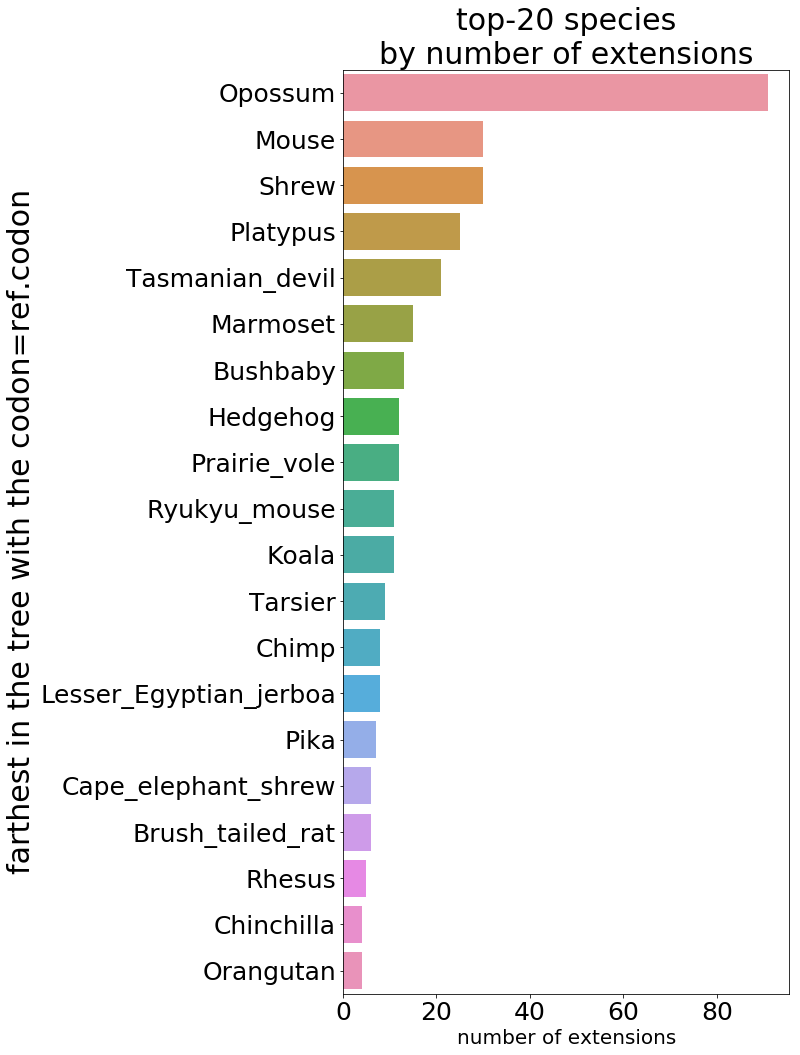

In [32]:
ax, fig = plt.subplots(figsize = (8,17))

ax = sns.barplot(y="the_furthest_animal", x="tr_id", data=tmp, orient='h')

#for tick in ax.get_xticklabels():
    #tick.set_rotation(90)
    
ax.set_yticklabels(labels = tmp.the_furthest_animal.tolist(), fontsize=25)
ax.set_xticklabels(labels = list(range(0, 100, 20)), fontsize=25)

ax.set_ylabel('farthest in the tree with the codon=ref.codon', fontsize=30)
ax.set_xlabel('number of extensions', fontsize=20)

ax.set_title('top-20 species\nby number of extensions', fontsize=30)

plt.show()

# Plot (order)

In [37]:
the_furthest_animal_df[the_furthest_animal_df['ref_codon'] != 'ATG'][0:4]

,tr_id,gene,ref_codon,the_furthest_animal,the_furthest_animal_dist,the_furthest_animal_d,specie_codon_dict,orders
0,ENST00000379389.4,ISG15,ATC,Chinese_hamster,0.493853,"{'Chimp': 0.012420419999999998, 'Bonobo': 0.01...","{'Chimp': 'ATC', 'Bonobo': 'ATC', 'Gorilla': '...","{'Primatomorpha': 18, 'Glires': 1, 'Cetartioda..."
1,ENST00000349431.10,UBE2J2,ACG,Mouse,0.530890,"{'Chimp': 0.012420419999999998, 'Bonobo': 0.01...","{'Chimp': 'ACG', 'Bonobo': 'ACG', 'Gorilla': '...","{'Primatomorpha': 19, 'Glires': 10, 'Cetartiod..."
2,ENST00000338370.7,AURKAIP1,ATT,Chinchilla,0.414003,"{'Chimp': 0.012420419999999998, 'Bonobo': 0.01...","{'Chimp': 'ATT', 'Bonobo': 'ATT', 'Gorilla': '...","{'Primatomorpha': 5, 'Glires': 1}"
3,ENST00000235310.7,MAD2L2,GTG,Opossum,0.798597,"{'Chimp': 0.012420419999999998, 'Bonobo': 0.01...","{'Chimp': 'GTG', 'Bonobo': 'GTG', 'Gorilla': '...","{'Primatomorpha': 21, 'Glires': 11, 'Cetartiod..."


In [33]:
li = []

for el in the_furthest_animal_df[the_furthest_animal_df['ref_codon'] != 'ATG'].to_numpy():
    orders = el[-1]
    tr_id = el[0]
    for k in orders:
        li.append([tr_id, k])
    
tmp = pd.DataFrame(li, columns = ['tr_id', 'order']).groupby('order').count().reset_index() 

tmp

,order,tr_id
0,Atlantogenata,237
1,Cetartiodactyla,242
2,Chiroptera,225
3,Eulipotyphla,174
4,Ferae,227
5,Glires,270
6,NonPlacental,146
7,Perissodactyla,204
8,Primatomorpha,392


In [39]:
#primates > Euarchontoglires -> placental mammals -> mammals -> vertebrates -> chordata>animals -> others


d = {'Primates': ['Primatomorpha'],
 'Euarchontoglires' : ['Primatomorpha', 'Glires'], 
 'Placental mammals': ['Primatomorpha', 'Glires', 'Atlantogenata', 'Cetartiodactyla', 'Chiroptera',
                      'Eulipotyphla', 'Ferae', 'Perissodactyla'],  
 'Mammalas': ['Primatomorpha', 'Glires', 'Atlantogenata', 'Cetartiodactyla', 'Chiroptera',
                      'Eulipotyphla', 'Ferae', 'Perissodactyla', 'NonPlacental']}

d = {'Primates': 392,  # Start codon in extensions of 392 genes can be found in at least one species from that taxon 
     'Euarchontoglires': # 
     'Placental mammals': 
     'Mammalas':}



# let's choose anumals 
# count number of extensions containing the same codon 
# plot tree 



In [ ]:
# so all extensions have start codon present in at least one primate specie in addition to human reference 

# X % of extensions have start codon present in at least one primate specie in addition to human reference 

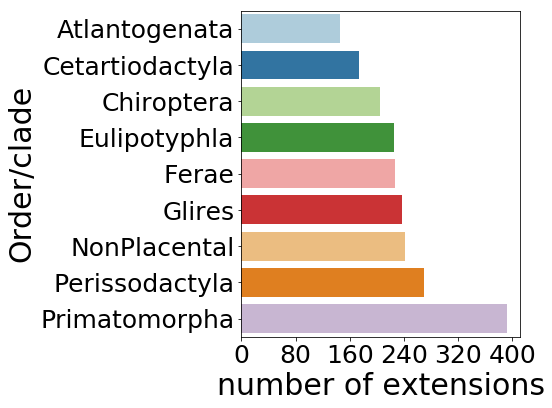

In [34]:
ax, fig = plt.subplots(figsize = (5,6))

sns.set_palette("Paired") 

ax = sns.barplot(y="order", x="tr_id", data=tmp, orient='h', order=tmp.sort_values(by='tr_id')['order'])

ax.set_yticklabels(labels = tmp.order.tolist(), fontsize=25)
ax.set_xticks(list(range(0, 420, 80)))
ax.set_xticklabels(labels = list(range(0, 420, 80)), fontsize=25)

ax.set_ylabel('Order/clade', fontsize=30)
ax.set_xlabel('number of extensions', fontsize=30)

ax.set_title('', fontsize=30)

plt.show()

In [76]:
tmp.sort_values(by='tr_id')

,order,tr_id
6,NonPlacental,146
3,Eulipotyphla,174
7,Perissodactyla,204
2,Chiroptera,225
4,Ferae,227
0,Atlantogenata,237
1,Cetartiodactyla,242
5,Glires,270
8,Primatomorpha,392


In [34]:
242/392

0.6173469387755102

In [35]:
237/392

0.6045918367346939

# Let's choose a handful of representative animals and show in how many of them start codon of extension is present 

In [50]:
taxonomy['species'].tolist()

['Chimp',
 'Bonobo',
 'Gorilla',
 'Orangutan',
 'Gibbon',
 'Rhesus',
 'Crab_eating_macaque',
 'Pig_tailed_macaque',
 'Baboon',
 'Drill',
 'Sooty_mangabey',
 'Green_monkey',
 'Proboscis_monkey',
 'Golden_snub_nosed_monkey',
 'Black_snub_nosed_monkey',
 'Angolan_colobus',
 'Ugandan_red_Colobus',
 'Marmoset',
 'Mas_night_monkey',
 'Squirrel_monkey',
 'White_faced_sapajou',
 'Tarsier',
 'Bushbaby',
 'Mouse_lemur',
 'Sifaka',
 'Malayan_flying_lemur',
 'Chinese_tree_shrew',
 'Lesser_Egyptian_jerboa',
 'Prairie_vole',
 'Chinese_hamster',
 'Golden_hamster',
 'Prairie_deer_mouse',
 'Mouse',
 'Ryukyu_mouse',
 'Shrew_mouse',
 'Rat',
 'Mongolian_gerbil',
 'Upper_Galilee_mountains_blind_mole_rat',
 'American_beaver',
 'Ords_kangaroo_rat',
 'Naked_mole_rat',
 'Damara_mole_rat',
 'Guinea_pig',
 'Chinchilla',
 'Brush_tailed_rat',
 'Squirrel',
 'Alpine_marmot',
 'Rabbit',
 'Pika',
 'Alpaca',
 'Wild_bactrian_camel',
 'Bactrian_camel',
 'Arabian_camel',
 'Bottlenose_dolphin',
 'Killer_whale',
 'Beluga_wh

In [55]:
species_li = ['Human',
 'Chimp',
 'Green_monkey',
 'Mouse',
 'Rat',
 'Beluga_whale',
 'Pig',
 'Horse',
 'White_rhinoceros',
 'Cat',
 'Chinese_pangolin',
 'Microbat',
 'Common_vampire_bat',
 'Hedgehog',
 'Shrew',
 'Elephant',
 'Armadillo',
 'Opossum',
 'Koala']

In [71]:
from collections import OrderedDict

li = []

for el in the_furthest_animal_df[the_furthest_animal_df['ref_codon'] != 'ATG'].to_numpy():
    ref_codon = el[2]
    gene = el[1]
    d = el[6]
    
    for sp, c in d.items():
        if sp in species_li:
            if c == ref_codon:
                li.append([gene, sp])
                
tmp = pd.DataFrame(li, columns = ['gene', 'specie']).groupby(by='specie').count().reset_index()

tmp['numbers'] = tmp['specie']+'_'+tmp['gene'].astype(str)

tmp = pd.DataFrame({'specie':['Human',
 'Chimp',
 'Green_monkey',
 'Mouse',
 'Rat',
 'Beluga_whale',
 'Pig',
 'Horse',
 'White_rhinoceros',
 'Cat',
 'Chinese_pangolin',
 'Microbat',
 'Common_vampire_bat',
 'Hedgehog',
 'Shrew',
 'Elephant',
 'Armadillo',
 'Opossum',
 'Koala']}).merge(tmp, on='specie')

d = dict(zip(tmp['specie'].tolist(), tmp['numbers'].tolist()))

OrderedDict(d).values()

odict_values(['Chimp_391', 'Green_monkey_313', 'Mouse_113', 'Rat_123', 'Beluga_whale_164', 'Pig_124', 'Horse_159', 'White_rhinoceros_137', 'Cat_142', 'Chinese_pangolin_116', 'Microbat_105', 'Common_vampire_bat_114', 'Hedgehog_124', 'Shrew_89', 'Elephant_126', 'Armadillo_132', 'Opossum_120', 'Koala_48'])

# Add multiple sequence alignment of the very conserved examples 

In [36]:
# taxonomy.groupby(0)['species'].apply(list).to_dict()

In [62]:
# taxonomy.groupby(0)['species'].apply(list).to_dict()

sel_species = ['Armadillo', 'Elephant', 'Manatee', # 'Atlantogenata'
               'Pig', 'Cow', 'Beluga_whale', 'Wild_bactrian_camel', # 'Cetartiodactyla' 
               'Microbat', 'Common_vampire_bat', 'Large_flying_fox', # 'Chiroptera'
               'Hedgehog', 'Shrew', 'Star_nosed_mole', # 'Eulipotyphla'
               'Cat', 'Weddell_seal', 'Chinese_pangolin', # 'Ferae'
                'Mouse', 'Rat', 'Rabbit',# 'Glires'
               'Opossum', 'Koala',  'Tasmanian_devil',# 'NonPlacental'
               'Horse', 'White_rhinoceros', 'Przewalski_horse', # 'Perissodactyla'
               'Chimp', 'Green_monkey', 'Human'# 'Primatomorpha'
]

In [63]:
conservation_df[(conservation_df['ref_codon_fraction'] > 0.94) & (conservation_df['number_of_species'] > 100)][0:2]

,tr_id,codon_start,nte_start,ref_codon,number_of_species,ref_codon_count,ref_codon_fraction,counter_codon,near_cognate_codon_count,near_cognate_codon_fraction,specie_codon_dict,animals_li,gene
14,ENST00000357214.5,36,0,GTG,115,114,0.991304,"{'GTG': 114, 'GNN': 1}",114,0.991304,"{'Chimp': 'GTG', 'Bonobo': 'GTG', 'Gorilla': '...","[Human, Chimp, Bonobo, Gorilla, Orangutan, Rhe...",SFPQ
15,ENST00000321358.11,43,1,CTG,107,104,0.971963,"{'CTG': 104, '': 3}",104,0.971963,"{'Chimp': 'CTG', 'Bonobo': 'CTG', 'Gorilla': '...","[Human, Chimp, Bonobo, Gorilla, Orangutan, Gib...",YBX1


In [72]:
codon_aln, full_aln, tis_aln, sliced_array_TIS_and_surroundings, ids_li = kek['ENST00000357214.5']

In [73]:
sliced_array_TIS_and_surroundings

[['C',
  'C',
  'A',
  'T',
  'T',
  'T',
  'T',
  'G',
  'T',
  'G',
  'A',
  'G',
  '-',
  'A',
  'A',
  'G',
  'C',
  'A',
  'A',
  '-',
  'G',
  'G',
  'T',
  'G',
  'G',
  'C',
  'C',
  'T',
  'C',
  'C',
  'A',
  'C',
  'G',
  'T',
  'T',
  'T',
  'C',
  'C',
  'T',
  'G',
  'A'],
 ['C',
  'C',
  'A',
  'T',
  'T',
  'T',
  'T',
  'G',
  'T',
  'G',
  'A',
  'G',
  '-',
  'A',
  'A',
  'G',
  'C',
  'A',
  'A',
  '-',
  'G',
  'G',
  'T',
  'G',
  'G',
  'C',
  'C',
  'T',
  'C',
  'C',
  'A',
  'C',
  'G',
  'T',
  'T',
  'T',
  'C',
  'C',
  'T',
  'G',
  'A'],
 ['C',
  'C',
  'A',
  'T',
  'T',
  'T',
  'T',
  'G',
  'T',
  'G',
  'A',
  'G',
  '-',
  'A',
  'A',
  'G',
  'C',
  'A',
  'A',
  '-',
  'G',
  'G',
  'T',
  'G',
  'G',
  'C',
  'C',
  'T',
  'C',
  'C',
  'A',
  'C',
  'G',
  'T',
  'T',
  'T',
  'C',
  'C',
  'T',
  'G',
  'A'],
 ['C',
  'C',
  'A',
  'T',
  'T',
  'T',
  'T',
  'G',
  'T',
  'G',
  'A',
  'G',
  '-',
  'A',
  'A',
  'G',
  'C',
  'A',
  'A',
  '

In [77]:
colors = []

f = open('tmp_res/ENST00000357214.5_TIS_10nt_msa.fasta', 'w')

for el, sp in zip(pd.DataFrame(sliced_array_TIS_and_surroundings).to_numpy(), ids_li):
    #print (sp, ''.join(el))
    if sp in sel_species:
        
        if sp == 'Human':
            label = 'Primatomorpha'
        else:
            label = taxonomy[taxonomy['species'] == sp].iloc[0][0]
        
        print (sp, label)
        colors_d = dict(zip(tmp.sort_values(by='tr_id')['order'].tolist(), sns.color_palette("Paired")))
        
        #print ('color: ', colors_d[label])
               
        f.write('>'+sp+'\n')
        f.write(''.join(el).replace('T', 'U')[:-1]+'\n')
        
        colors.append(colors_d[label])
    
f.close()

Human Primatomorpha
Chimp Primatomorpha
Green_monkey Primatomorpha
Mouse Glires
Rat Glires
Rabbit Glires
Wild_bactrian_camel Cetartiodactyla
Beluga_whale Cetartiodactyla
Cow Cetartiodactyla
Pig Cetartiodactyla
Horse Perissodactyla
Przewalski_horse Perissodactyla
White_rhinoceros Perissodactyla
Cat Ferae
Weddell_seal Ferae
Chinese_pangolin Ferae
Large_flying_fox Chiroptera
Microbat Chiroptera
Common_vampire_bat Chiroptera
Hedgehog Eulipotyphla
Shrew Eulipotyphla
Star_nosed_mole Eulipotyphla
Elephant Atlantogenata
Manatee Atlantogenata
Armadillo Atlantogenata
Opossum NonPlacental
Tasmanian_devil NonPlacental
Koala NonPlacental


In [48]:
colors = []

f = open('tmp_res/ENST00000357214.5_TIS_msa.fasta', 'w')

for el, sp in zip(pd.DataFrame(tis_aln).to_numpy(), ids_li):
    #print (sp, ''.join(el))
    if sp in sel_species:
        
        if sp == 'Human':
            label = 'Primatomorpha'
        else:
            label = taxonomy[taxonomy['species'] == sp].iloc[0][0]
        
        print (sp, label)
        colors_d = dict(zip(tmp.sort_values(by='tr_id')['order'].tolist(), sns.color_palette("Paired")))
        
        #print ('color: ', colors_d[label])
               
        f.write('>'+sp+'\n')
        f.write(''.join(el).replace('T', 'U')[:-1]+'\n')
        
        colors.append(colors_d[label])
    
f.close()

Human Primatomorpha
Chimp Primatomorpha
Green_monkey Primatomorpha
Mouse Glires
Rat Glires
Rabbit Glires
Wild_bactrian_camel Cetartiodactyla
Beluga_whale Cetartiodactyla
Cow Cetartiodactyla
Pig Cetartiodactyla
Horse Perissodactyla
Przewalski_horse Perissodactyla
White_rhinoceros Perissodactyla
Cat Ferae
Weddell_seal Ferae
Chinese_pangolin Ferae
Large_flying_fox Chiroptera
Microbat Chiroptera
Common_vampire_bat Chiroptera
Hedgehog Eulipotyphla
Shrew Eulipotyphla
Star_nosed_mole Eulipotyphla
Elephant Atlantogenata
Manatee Atlantogenata
Armadillo Atlantogenata
Opossum NonPlacental
Tasmanian_devil NonPlacental
Koala NonPlacental


In [49]:
colors

[(0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 0.4980392156862745, 0.0),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.2, 0.6274509803921569, 0.17

In [42]:
taxonomy[taxonomy['species'] == 'Koala']

,0,1,label,species
117,NonPlacental,Koala (Phascolarctos cinereus): HLphaCin1,HLphaCin1,Koala


In [43]:
tips = ['hg38','panTro5','chlSab2','mm10','rn6','HLdelLeu1','susScr11','HLequCab3','cerSim1',
        'felCat8','manPen1','myoLuc2',
        'HLdesRot1','eriEur2','sorAra2','loxAfr3','dasNov3','monDom5','HLphaCin1']

In [44]:
sel_species2 = []

for sp in tips:
    if sp == 'hg38':
        sel_species2.append('Human')
    else:
        sel_species2.append(taxonomy[taxonomy['label'] == sp].iloc[0].species)

In [45]:
sel_species2 

['Human',
 'Chimp',
 'Green_monkey',
 'Mouse',
 'Rat',
 'Beluga_whale',
 'Pig',
 'Horse',
 'White_rhinoceros',
 'Cat',
 'Chinese_pangolin',
 'Microbat',
 'Common_vampire_bat',
 'Hedgehog',
 'Shrew',
 'Elephant',
 'Armadillo',
 'Opossum',
 'Koala']

In [46]:
meta[meta['tr_id'] == 'ENST00000357214.5']

,tr_id,N_term_start,N_term_end,len,N_term_start1,N_term_end1,len_codons,gene,50len_flag,global_coo_50_and_less,...,gene_ext,Start_ext,Stop_ext,global_rank_ext,Start_codon_ext,Proteomics_count_ext,Coverage_value_ext,CDS_ratio,Riboseq_Summary,Nstart_Nend
1558,ENST00000357214.5,0,99,99,0,99,33.0,SFPQ,0,chr1:35193050-35193148,...,SFPQ,37.0,100.0,9.0,GTG,11.538462,81.25,0.59,GTG; 37-100; Rank: 9; cov: 81.25,0-99


# Let's look at primatomorpha and find

In [47]:
conservation_df

,tr_id,codon_start,nte_start,ref_codon,number_of_species,ref_codon_count,ref_codon_fraction,counter_codon,near_cognate_codon_count,near_cognate_codon_fraction,specie_codon_dict,animals_li,gene
0,ENST00000379389.4,97,1,ATC,111,33,0.297297,"{'ATC': 33, 'TTC': 2, '': 7, 'GTCTTCGCCCGACCGG...",36,0.324324,"{'Chimp': 'ATC', 'Bonobo': 'ATC', 'Gorilla': '...","[Human, Chimp, Bonobo, Gorilla, Orangutan, Gib...",ISG15
1,ENST00000349431.10,172,28,ACG,82,58,0.707317,"{'ACG': 58, 'ACA': 1, 'AGG': 2, 'GCA': 1, 'GCG...",60,0.731707,"{'Chimp': 'ACG', 'Bonobo': 'ACG', 'Gorilla': '...","[Human, Chimp, Bonobo, Gorilla, Orangutan, Gib...",UBE2J2
2,ENST00000338370.7,104,2,ATT,113,6,0.053097,"{'ATT': 6, 'ATC': 14, '': 27, 'AGC': 7, 'AGA':...",21,0.185841,"{'Chimp': 'ATT', 'Bonobo': 'ATT', 'Gorilla': '...","[Human, Chimp, Bonobo, Gorilla, Orangutan, Rhe...",AURKAIP1
3,ENST00000235310.7,860,782,GTG,111,65,0.585586,"{'GTG': 65, '': 17, 'GAG': 5, 'GCG': 9, 'GTT':...",69,0.621622,"{'Chimp': 'GTG', 'Bonobo': 'GTG', 'Gorilla': '...","[Human, Chimp, Bonobo, Gorilla, Orangutan, Rhe...",MAD2L2
4,ENST00000356634.7,62,2,GTG,103,70,0.679612,"{'GTG': 70, 'GCG': 7, 'GTC': 1, 'GAG': 11, 'GG...",71,0.689320,"{'Chimp': 'GTG', 'Bonobo': 'GTG', 'Gorilla': '...","[Human, Chimp, Bonobo, Gorilla, Orangutan, Rhe...",KDM1A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,ENST00000330374.6,45,0,CTG,100,32,0.320000,"{'CTG': 32, '': 11, 'CCG': 7, 'TAG': 1, 'CT': ...",38,0.380000,"{'Chimp': 'CTG', 'Bonobo': 'CTG', 'Gorilla': '...","[Human, Chimp, Bonobo, Gorilla, Orangutan, Gib...",VMA21
391,ENST00000370274.7,119,2,CTG,119,82,0.689076,"{'CTG': 82, '': 8, 'GTG': 4, 'CGG': 7, 'TTG': ...",92,0.773109,"{'Chimp': 'CTG', 'Bonobo': 'CTG', 'Gorilla': '...","[Human, Chimp, Bonobo, Gorilla, Orangutan, Gib...",NSDHL
392,ENST00000447750.6,251,197,GTG,90,15,0.166667,"{'GTG': 15, '': 18, 'GCG': 53, 'GC': 1, 'GCGGC...",15,0.166667,"{'Chimp': 'GTG', 'Bonobo': 'GTG', 'Gorilla': '...","[Human, Chimp, Bonobo, Gorilla, Orangutan, Gib...",GDI1
393,ENST00000381401.10_PAR_Y,682,640,CTG,50,18,0.360000,"{'CTG': 18, 'CTA': 1, '': 21, 'CCG': 1, 'TTG':...",19,0.380000,"{'Chimp': 'CTG', 'Gorilla': 'CTG', 'Orangutan'...","[Human, Chimp, Gorilla, Orangutan, Gibbon, Rhe...",SLC25A6
